Libraries

In [12]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

Data

In [3]:
# Retrieve attribute names in order
attribute_names = list(np.load('../gen_train_data/data/output/attributes.npy', allow_pickle=True))

# Load test data
X_test_pre = np.load('../gen_train_data/data/output/pre/X_test_pre.npy', allow_pickle=True)
y_test_pre = np.load('../gen_train_data/data/output/pre/y_test_pre.npy', allow_pickle=True)
X_test_post = np.load('../gen_train_data/data/output/post/X_test_post.npy', allow_pickle=True)
y_test_post = np.load('../gen_train_data/data/output/post/y_test_post.npy', allow_pickle=True)

# Type conversion needed    
data_dic = {
    "X_test_pre": pd.DataFrame(X_test_pre, columns=attribute_names).convert_dtypes(),
    "y_test_pre": y_test_pre,
    "X_test_post": pd.DataFrame(X_test_post, columns=attribute_names).convert_dtypes(),
    "y_test_post": y_test_post,
}

In [4]:
method_names = {
    0: "ORIG",
    1: "ORIG_CW",
    2: "OVER",
    3: "UNDER"
}
model_choices = {
    "ORIG": "XGB",
    "ORIG_CW": "RF",
    "OVER": "XGB",
    "UNDER": "XGB"
}

soc_var_names = np.load('../EDA/soc_vars_names.npy', allow_pickle=True)
ind_var_names = np.load('../EDA/ind_vars_names.npy', allow_pickle=True)

##### SHAP Plots

In [ ]:
method_name = 'OVER'
plt.figure(figsize=(35, 75))
for i, group in enumerate(['pre', 'post']):
            X_test = data_dic['X_test_' + group]
            y_test = data_dic['y_test_' + group]
            model_name = model_choices[method_name]
            shap_vals = np.load(f'./output/shap_values/{group}_{method_name}.npy')
            ax = plt.subplot(2,1,i+1)
            shap.summary_plot(shap_vals, X_test, max_display=len(attribute_names), show=False)
            plt.title(group.upper(), fontsize = 12, fontweight='bold')
            plt.xlabel('SHAP Value')
            plt.xlim(-3,5)
            used_colors = {'purple': 'Social factor', 'green': 'Individual factor'}
            for label in ax.get_yticklabels():
                label_text = label.get_text()  # Get the text of the label
                label.set_fontsize(8)
                if label_text in soc_var_names:
                        label.set_color('purple')
                else:
                        label.set_color('green')
                # Create custom legend for each subplot
                handles = [mpatches.Patch(color=color, label=label) for color, label in used_colors.items()]
                ax.legend(handles=handles, loc='lower right', fontsize=8)
            
plt.suptitle(f'SHAP Summary Plots PRE vs POST - Pipeline: Oversampling - Model: {model_name}\n\n')
plt.subplots_adjust(wspace=1)
plt.tight_layout()
plt.savefig(f'./output/plots/shap_summary/{method_name}_{model_name}.svg', format='svg', dpi=1250)
plt.show()

In [ ]:
method_name = 'ORIG_CW'
plt.figure(figsize=(35, 75))
for i, group in enumerate(['pre', 'post']):
            X_test = data_dic['X_test_' + group]
            y_test = data_dic['y_test_' + group]
            model_name = model_choices[method_name]
            shap_vals = np.load(f'./output/shap_values/{group}_{method_name}.npy')
            shap_vals = shap_vals[:,:,1] # Select shap values for positive class
            ax = plt.subplot(2,1,i+1)
            shap.summary_plot(shap_vals, X_test, max_display=len(attribute_names), show=False)
            plt.title(group.upper(), fontsize = 12, fontweight='bold')
            plt.xlabel('SHAP Value')
            plt.xlim(-0.5,0.5)
            used_colors = {'purple': 'Social factor', 'green': 'Individual factor'}
            for label in ax.get_yticklabels():
                label_text = label.get_text()  # Get the text of the label
                label.set_fontsize(8)
                if label_text in soc_var_names:
                        label.set_color('purple')
                else:
                        label.set_color('green')
                # Create custom legend for each subplot
                handles = [mpatches.Patch(color=color, label=label) for color, label in used_colors.items()]
                ax.legend(handles=handles, loc='lower right', fontsize=8)

plt.suptitle(f'SHAP Summary Plots PRE vs POST - Pipeline: Original with Class Weight - Model: {model_name}\n\n')
plt.subplots_adjust(wspace=1)
plt.tight_layout()
plt.savefig(f'./output/plots/shap_summary/{method_name}_{model_name}.svg', format='svg', dpi=1250)
plt.show()

##### SHAP Interaction Plots

Had to modify beeswarm.py (line 591)

In [ ]:
method_name = 'ORIG_CW'
group = 'pre'

In [ ]:
X_test = data_dic['X_test_' + group]
y_test = data_dic['y_test_' + group]
model_name = model_choices[method_name]

shap_inter_vals = np.load(f'./output/shap_inter_values/{group}_{method_name}.npy')
if method_name == 'ORIG_CW':
      shap_inter_vals = shap_inter_vals[:,:,:,1] # Take info about positive class

num_instances = shap_inter_vals.shape[0]  # Dynamically get the number of instances
num_features = shap_inter_vals.shape[1]  # Assuming the number of features is the second dimension size
# Loop over each instance and set the diagonal and lower triangle of each 39x39 matrix to NaN
for i in range(num_instances):
    # Mask the diagonal
    np.fill_diagonal(shap_inter_vals[i], np.nan)
    # Get indices for the lower triangle, excluding the diagonal
    lower_triangle_indices = np.tril_indices(num_features, -1)  # -1 excludes the diagonal
    # Set the lower triangle to NaN
    shap_inter_vals[i][lower_triangle_indices] = np.nan

plt.figure(figsize=(10,10))
shap.summary_plot(shap_inter_vals, X_test, show=False, sort=False)
fig=plt.gcf()
attr_names = []
used_colors = {'purple': 'Social factor', 'green': 'Individual factor'}
# Iterate over all axes in the figure
for ax in fig.get_axes():
    # Customize the y-axis tick labels
    for label in ax.get_yticklabels():
        label_text = label.get_text()  # Get the text of the label
        attr_names.append(label_text)
        label.set_fontsize(12)
        if label_text in soc_var_names:
                label.set_color('purple')
        else:
                label.set_color('green')

# Assuming the top labels are treated as titles, let's try to modify them
total_axes = len(fig.axes)
for i, ax in enumerate(fig.axes):
        reverse_index = total_axes - 1 - i
        title = attr_names[reverse_index]
        ax.set_title(title, color='purple' if title in soc_var_names else 'green', fontsize=12, rotation=90)
        if method_name == 'ORIG_CW':
              ax.set_xlim(-0.15, 0.15) # Use same scale for pre and post
        elif method_name == 'OVER':
              ax.set_xlim(-2,2)

# Create a single general legend for the whole figure
handles = [mpatches.Patch(color=color, label=label) for color, label in used_colors.items()]
fig.legend(handles=handles, loc='lower right', fontsize=12)

plt.suptitle(f'Simplified Example SHAP Summary Interaction Plot\n', fontsize=15, fontweight='bold', x=0.5, y=0.95, ha='center')
plt.tight_layout()
plt.savefig(f'./output/plots/shap_inter_summary/example.svg', format='svg', dpi=600)
plt.show()

##### SHAP Interaction Analysis

In [17]:
method_name = 'OVER'

In [18]:
# Normalization function
def max_absolute_scale(matrix):
    return matrix / np.max(np.abs(matrix))

In [19]:
# Load array of shap inter matrices for pre and post for the chosen method
shap_inter_vals_pre = np.load(f'./output/shap_inter_values/pre_{method_name}.npy')
shap_inter_vals_post = np.load(f'./output/shap_inter_values/post_{method_name}.npy')
if method_name == 'ORIG_CW':
    shap_inter_vals_pre = shap_inter_vals_pre[:,:,:,1] # Take info about positive class
    shap_inter_vals_post = shap_inter_vals_post[:,:,:,1]

# Normalize each matrix in each of the two arrays
norm_shap_inter_vals_pre = np.array([max_absolute_scale(matrix) for matrix in shap_inter_vals_pre])
norm_shap_inter_vals_post = np.array([max_absolute_scale(matrix) for matrix in shap_inter_vals_post])

# Aggregate matrices in each group by calculating the mean
agg_shap_inter_vals_pre = np.mean(norm_shap_inter_vals_pre, axis=0)
agg_shap_inter_vals_post = np.mean(norm_shap_inter_vals_post, axis=0)

# Compute the difference between the aggregated matrices and take the absolute value
diff_matrix = np.abs(agg_shap_inter_vals_post - agg_shap_inter_vals_pre)

In [87]:
def plot_inter_heatmap(matrix, feature_names, soc_var_names, method_name, group):
    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(matrix, dtype=bool))

    # Create the heatmap using Seaborn
    plt.figure(figsize=(12, 12))
    ax = sns.heatmap(matrix, mask=mask, cmap='RdBu', center=0, annot=False, cbar=True,
                xticklabels=feature_names, yticklabels=feature_names)
    
    for tick_label in ax.get_yticklabels():
        if tick_label.get_text() in soc_var_names:
            tick_label.set_color('purple')  # Specific social variables
        else:
            tick_label.set_color('green')  # Other variables
    
    for tick_label in ax.get_xticklabels():
        if tick_label.get_text() in soc_var_names:
            tick_label.set_color('purple')  # Specific social variables
        else:
            tick_label.set_color('green')  # Other variables
        
    plt.title(f'Mean Interaction Matrix - Pipeline: {method_name} - Group: {group}\n', fontdict={'fontstyle': 'normal', 'weight': 'bold'})
    # Create a custom legend
    purple_patch = mpatches.Patch(color='purple', label='Social factor')
    green_patch = mpatches.Patch(color='green', label='Individual factor')
    plt.legend(handles=[purple_patch, green_patch], loc='upper right')
    # Add a title to the color bar
    cbar = ax.collections[0].colorbar
    cbar.set_label('Normalized SHAP Interaction Value', labelpad=15, rotation=270, verticalalignment='bottom')
    
    plt.savefig(f'./output/plots/heatmaps_interactions/{method_name}_{group}.svg', format='svg', dpi=600)
    plt.show()

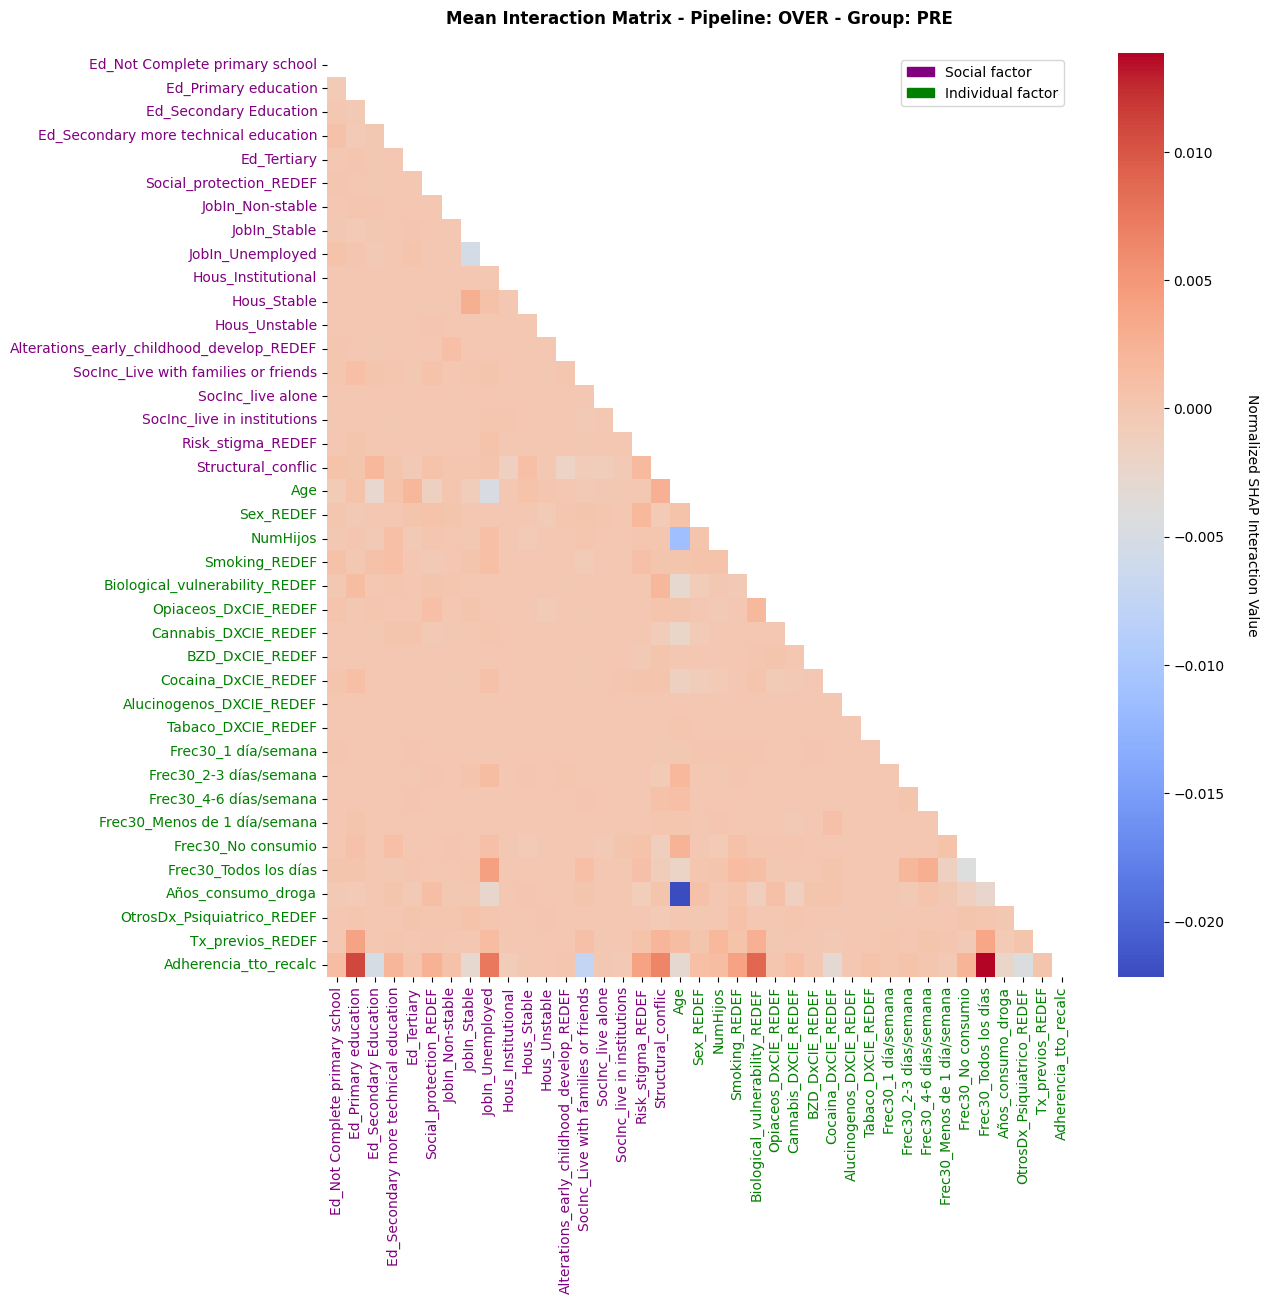

In [84]:
plot_inter_heatmap(agg_shap_inter_vals_pre, attribute_names, soc_var_names, method_name, 'PRE')

In [88]:
def plot_distance_heatmap(matrix, feature_names, soc_var_names, method_name):
    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(matrix, dtype=bool))

    # Create the heatmap using Seaborn
    plt.figure(figsize=(12, 12))
    ax = sns.heatmap(matrix, mask=mask, cmap=sns.color_palette("light:r", as_cmap=True), annot=False, cbar=True,
                xticklabels=feature_names, yticklabels=feature_names)

    for tick_label in ax.get_yticklabels():
        if tick_label.get_text() in soc_var_names:
            tick_label.set_color('purple')  # Specific social variables
        else:
            tick_label.set_color('green')  # Other variables
    
    for tick_label in ax.get_xticklabels():
        if tick_label.get_text() in soc_var_names:
            tick_label.set_color('purple')  # Specific social variables
        else:
            tick_label.set_color('green')  # Other variables
        
    plt.title(f'Distance Interaction Matrix between PRE and POST - Pipeline: {method_name}\n', fontdict={'fontstyle': 'normal', 'weight': 'bold'})
    # Create a custom legend
    purple_patch = mpatches.Patch(color='purple', label='Social factor')
    green_patch = mpatches.Patch(color='green', label='Individual factor')
    plt.legend(handles=[purple_patch, green_patch], loc='upper right')
    # Add a title to the color bar
    cbar = ax.collections[0].colorbar
    cbar.set_label('Abs (PRE - POST)', labelpad=15, rotation=270, verticalalignment='bottom')

    plt.savefig(f'./output/plots/heatmaps_interactions/DIST_{method_name}.svg', format='svg', dpi=600)
    
    plt.show()

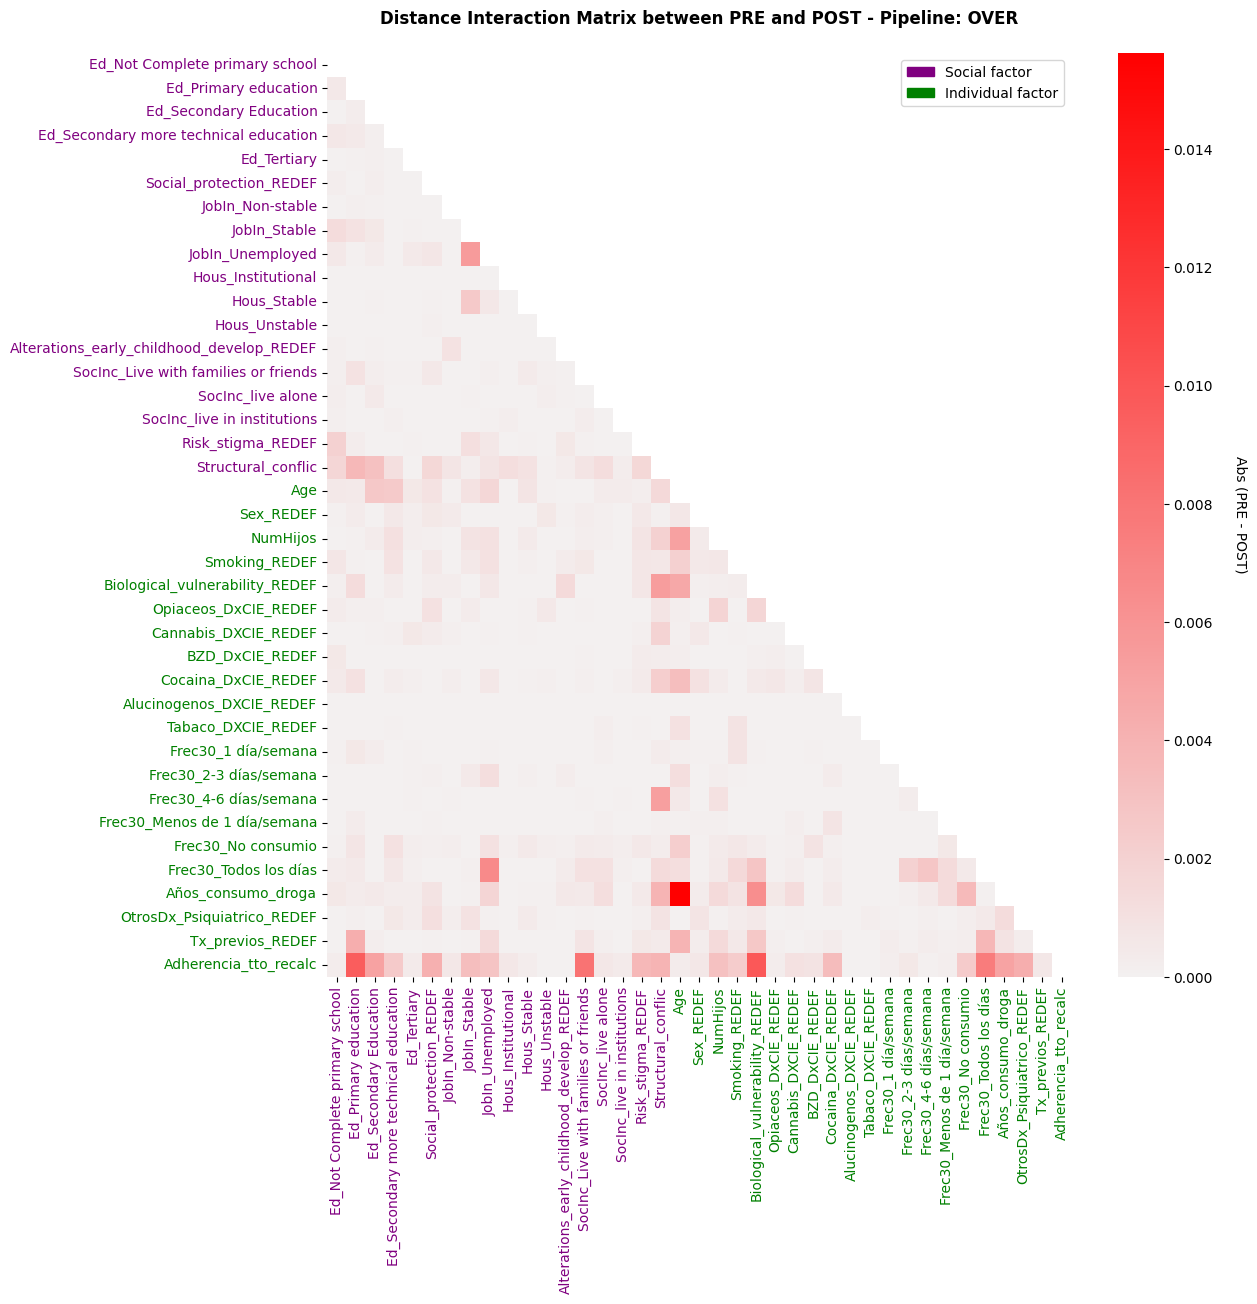

In [89]:
plot_distance_heatmap(diff_matrix, attribute_names, soc_var_names, method_name)